# Проект: Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечание:

- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train

# Данные

Данные находятся в файле /datasets/autos.csv.

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

# План работы

1. Загрузить данные и провести их подготовку.
2. Обучить несколько моделей моделей с использованием различных наборов гиперпараметров.
3. Провести анализ моделей и выбрать лучшую по результатам метрики RMSE и времени обучения.
4. Сделать выводы по результатам сравнений.

## Подготовка данных

### Загрузка моделей и данных. Обзор данных.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import time

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

# для загрузки файла из локального диска в гугл колаб
#from google.colab import files     
#import io

# используемые алгоритмы для обучения моделей
#! pip install catboost # для google colab

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# глобальные переменные
RANDOM_INIT = 42 # единый параметр random_state     
CV = 3           # количество folders при косс валидации

Выгружаем данные из таблицы и изучаем их. Сразу в коде предусматриваем несколько вариантов загрузки данных.

In [2]:
# вариант для работы в колабе
try:
    data = pd.read_csv('/datasets/autos.csv')  # серверный путь для jupyter
except:
    #data = pd.read_csv('С://Users//HOMMANDER//Documents//autos.csv') # локальный путь для jupyter
    
    uploaded = files.upload() #шаг1  локальный путь для google colab должен быть подключен модуль files из библиотеки google.colab
  #data = pd.read_csv(open('autos.csv','rb')) #шаг2 для google colab вариант 1  
  #data = pd.read_csv('autos.csv') #шаг2 для google colab Вариант 2
    
    data = pd.read_csv(io.BytesIO(uploaded['autos.csv'])) #шаг2 для google colab Вариант 3 нужна библиотека io

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Комментарий:**  Сразу исправляем заголовки для удобства работы. В данных есть пропуски, поэтому после исправления заголовков оцениваем количество пропусков.

In [4]:
# Приводим в более рабочий вид наименования заголовков параметров
data.columns.str.lower()
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code','last_seen']       

In [5]:
# Считаем % пропусков в параметрах и сортируем по убыванию для нагладности
print('атрибут:          % пропусков:')
print(round(data.isna().mean().sort_values(ascending=False)*100,0)) 

атрибут:          % пропусков:
not_repaired          20.0
vehicle_type          11.0
fuel_type              9.0
gearbox                6.0
model                  6.0
date_crawled           0.0
price                  0.0
registration_year      0.0
power                  0.0
kilometer              0.0
registration_month     0.0
brand                  0.0
date_created           0.0
number_of_pictures     0.0
postal_code            0.0
last_seen              0.0
dtype: float64


**Комментарий**: Колонки vehicle_type, gearbox, model, fuel_type, not_repaired  содержат большое количество пропусков. Это качественные параметры, изучим их содержимое:                                                

In [6]:
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired','brand']:
    print('Уникальные значения столбца', column)
    print(data[column].unique())    

Уникальные значения столбца vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца gearbox
['manual' 'auto' nan]
Уникальные значения столбца model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe

**Краткий план действий:**

Заполнению пропусков:
- предварительно все пропуски заполним словом 'unknown', что бы можно было сравнивать их.
- vehicle_type пропуски можно заполнить по модели, предварительно составив словарь.
- gearbox будем заполнять наиболее распространенным видом 'manual'
- model способ не просматривается, оставим как 'unknown'
- fuel_type заполняем по модели, предвариетльно составив словарь. 
- not_repaired будем заполнять 'yes' исходя из предположения о продаже не битой машины.

Значимость признаков:

- *vehicle_type, gearbox, power, kilometer, fuel_type, brand, not_repaired, registration_year, model* - вляиют на стоимость автомобиля, так как определяют его вид, состояние, происхождение, возраст и ликвидность.

- *date_crawled, number_of_pictures, last_seen, registration_month, date_created* - на цену не оказывают существенного влияния и для моделирования не требуются. Удаляем их из рабочего датафрейма, но оставим в исходном, предварительно переведя даты в числовой формат, если они понадобятся будет удобнее с ними работать.

- *postal_code* - c одной стороны,важный параметр, так как почтовый индекс уникален для региона, а цена регионально-зависимый параметр. Но без указания страны происхождения, данный параметр уже не уникальный, а просто набор непонятных цифр. Поэтому от него также можно избавиться, или проверить качество с ним, и без него.

Качество признаков:

- кроме пропусков, других аномалий или синонимов в значениях качественных параметров нет, редактирование не требуется
- не обязательно, но 'petrol' и 'gasoline' обозначают один вид топлива - английское и американское названия.
- почему то отсутствует 'diesel', наверное он в группе 'other'

Числовые признаки:

- Та как их удобнее отрабатывать сразу, то рассмотрим их в разделе подготовки данных.

### Подготовка данных

In [7]:
# Переведем в числовой формат колонки с датами в исходнике
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Удаление избыточной информации. 
# drop_list списко наименований "не значимых" признаков для их удаления
drop_list = ['date_crawled','date_created','number_of_pictures','last_seen','registration_month', 'postal_code']

#сменим рабочий датафрейм, предварительно удалив из исходного избыточную информацию
df = data.drop(drop_list, axis=1)

**Удаление, замена пропусков:**

In [9]:
# Пропуски есть только в категориальных параметрах, на первом этапе заменяем 'Nan' на 'unknown'
# cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
cat_features = list(df.select_dtypes(include='object').columns)

df[cat_features] = df[cat_features].fillna('unknown')

In [10]:
# функция возвращает словарь из ключей и значений ключа
# необходима для замен 'unknown' на значения из словаря по ключу
def get_words(data, keys, values):
    words = {}
    for key in data[keys].unique():
        if key != 'unknown':
            indikator = 0
            for value in data[data[keys] == key][values]:
                if value != 'unknown':
                    words[key] = value
                    indikator +=1
                    break
            if indikator == 0:
                words[key] = value
        else:
            words[key] = 'unknown'
    return words

#словари
words_vehicle = get_words(df, 'model', 'vehicle_type') # модель автомобиля - тип кузова
words_fuel = get_words(df, 'model','fuel_type')        # модель автомобиля - тип горючего (допущение)

In [11]:
#заполняем пропуски ожидаемыми самыми распространенными значениями
df[df['gearbox']=='unknown']['gearbox'] = 'manual'         # тип коробки передач ставим ручной (допущение)
df[df['not_repaired']=='unknown']['not_repaired'] = 'yes'  # автомобиль не былв ремонте

In [12]:
# функция для изменений 'unknown' в датафрейме на данные из словаря
def fill_unknown_from_dict(row, column, dic):
    model = row['model']
    if row[column] == 'unknown':
        return dic.get(model)
    return row[column]

# заполняем пропуски значениями из словарей
df['vehicle_type'] = df.apply(fill_unknown_from_dict, axis = 1, args=['vehicle_type', words_vehicle])
df['fuel_type'] = df.apply(fill_unknown_from_dict, axis = 1, args=['fuel_type', words_fuel])

**Удаление дубликатов:**

In [13]:
print('Количество строк - дубликатов = ',df.duplicated().sum())

Количество строк - дубликатов =  47218


In [14]:
# удаляем дубликаты
df = df.drop_duplicates(ignore_index=True)

**Работа с числовыми категориями**

***Распределение значений цены автомобилей:***

In [15]:
# Так как приходится строить графики несколько раз, 
# выделим построение гистограммы, ящика с усами и статистику в отдельную функцию plot_3g()
# column - рассматриваемая колонка - параметр (feature)
# title - заголовок группы графиков
def plot_3g(df, column, title):
    f, axs = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(title)
    axs[0].hist(df[column], bins=50, rwidth=0.7)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('number of objects')
    axs[1].boxplot(df[column])
    axs[1].set_xlabel(column)
    axs[1].xaxis.set_ticks([])
    axs[1].grid()
    axs[2].axes.yaxis.set_visible(False)
    axs[2].xaxis.set_ticks([]) 
    axs[2].set_xlabel('describe')
    for i in range(8):
        axs[2].text(0.2,0.1+i/10,df[column].describe().index[i])
        axs[2].text(0.6,0.1+i/10,str(round(df[column].describe().values[i],2)))

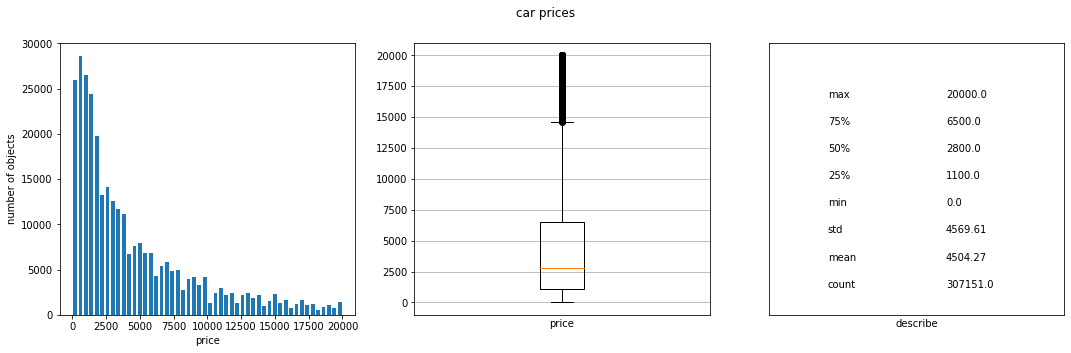

In [16]:
plot_3g(df,'price','car prices')

In [17]:
print(np.sort(df[df['price']<500]['price'].unique()))

[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  24  25  26  27  29  30  32  33  35  38  39  40  45  47  49
  50  55  58  59  60  65  66  69  70  74  75  77  79  80  85  88  89  90
  95  98  99 100 101 105 106 108 110 111 112 115 117 119 120 121 122 123
 125 126 127 128 129 130 132 133 135 139 140 142 145 149 150 155 156 157
 158 159 160 162 165 166 169 170 173 175 177 179 180 181 185 188 189 190
 192 193 195 196 198 199 200 202 205 209 210 211 215 217 219 220 222 224
 225 229 230 233 235 236 238 240 243 245 248 249 250 251 252 253 255 259
 260 261 263 265 266 269 270 272 273 274 275 277 278 279 280 281 284 285
 288 289 290 293 295 298 299 300 301 305 308 309 310 315 316 319 320 321
 323 325 329 330 331 332 333 335 338 339 340 341 344 345 348 349 350 355
 356 359 360 365 366 368 369 370 373 375 377 378 379 380 384 385 388 389
 390 393 395 397 398 399 400 408 410 414 415 418 419 420 422 424 425 429
 430 433 435 439 440 444 445 449 450 455 456 458 45

***Комментарий:*** Если опираться на интернет, то в Европе можно найти старый автомобиль за 250-300 евро, с учетом того, что утилизация стоит 100-200 евро, этому можно верить. Качество автомобиля за 250 евро, будет улилизационное, но не суть. Для нашего исследования важен тот факт, что реальная цена продажи не может быть ниже 250 евро. Что касается максимума, то здесь ограничений нет и 20000 евро не предел, и эти данные не будут являться выбросами, поэтому удалим из датафрейма только те объекты, на которые цена ниже 250 евро.

In [18]:
# отрезаем нереальные цены. Всё что ниже 250 евро
df = df[df['price'] > 250]

***Распределение значений года регистрации автомобилей:***

In [19]:
print(np.sort(df['registration_year'].unique()))

[1000 1001 1039 1111 1234 1300 1400 1500 1600 1602 1800 1910 1923 1925
 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2290 2500 2800 2900
 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5911 6000 7000
 7100 7800 8200 8500 8888 9000 9450 9999]


In [20]:
# Воспользуемся сохраненными исходниками. Определим верхнюю границу по датам создания анкет.
display(data['date_created'].max())            

Timestamp('2016-04-07 00:00:00')

***Комментарий*** Очевидно, что год регистрации автомобиля не можетбыть позже даты создания анкеты в базе данных. В нашемслучае самый поздний год 2016, автомобили серийно появились в начале 20-го века, так что нижнюю границу определим в 1900 год. Остальное удалим и смотрим статистику значений даты на графиках.

In [21]:
#registration_yearнижнюю границу выберем началом века
df = df[(df['registration_year']>1900)&(df['registration_year']<2017)]

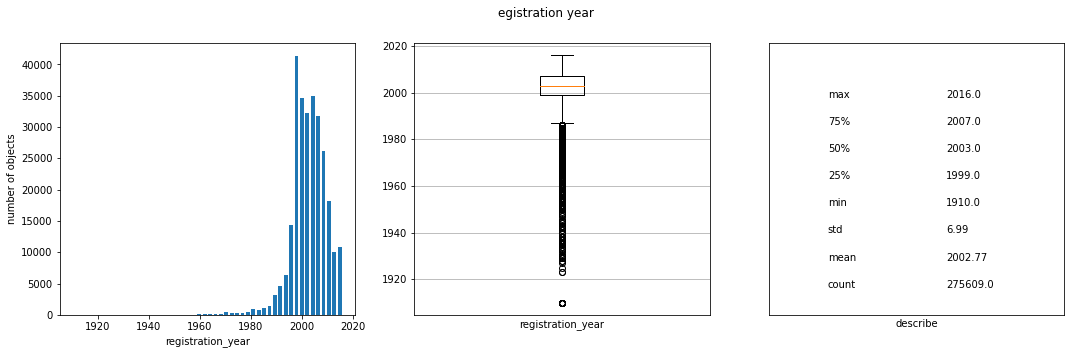

In [22]:
plot_3g(df,'registration_year','egistration year')

***Комментарий*** Видно, что даты регистрации до 1960 года можно считать выбросами и удалить. И да, версия с минимальной ценой на уровне 250 евро подтверждается. Наверняка в 2016 году, автомобили с датой регистрации 1960 года стоят не больше утилизационной стоимости, если это не раритет.

In [23]:
# Удаляем объекты с датой регистрации до 1960 года
df = df[df['registration_year']>1960]

***Распределение значений мощности автомобилей:***

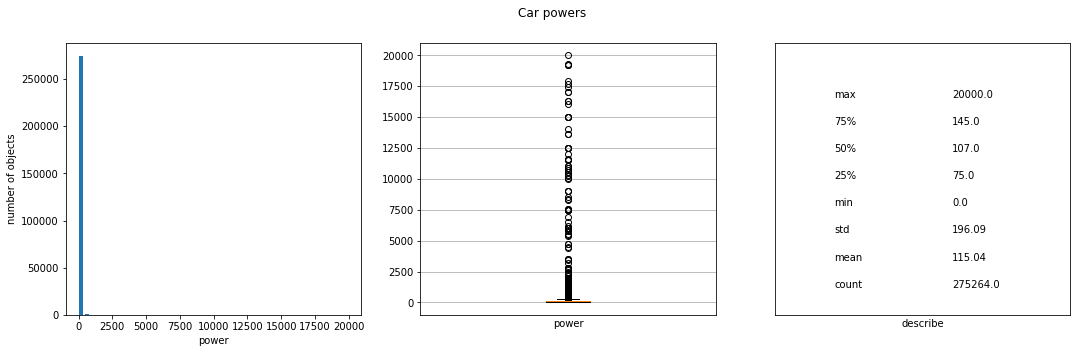

In [24]:
plot_3g(df,'power','Car powers')

***Комментарий*** Опираясь на источники в интернет, минимальную реальную мощность на серийные автомобили можно ограничить в 10 л.с. Максимальная 1500 л.с Все остальные значения на нашем графике будем считать аномалиями и выбросами, они нереальны.

In [25]:
df = df[(df['power']>9)&(df['power']<1501)]

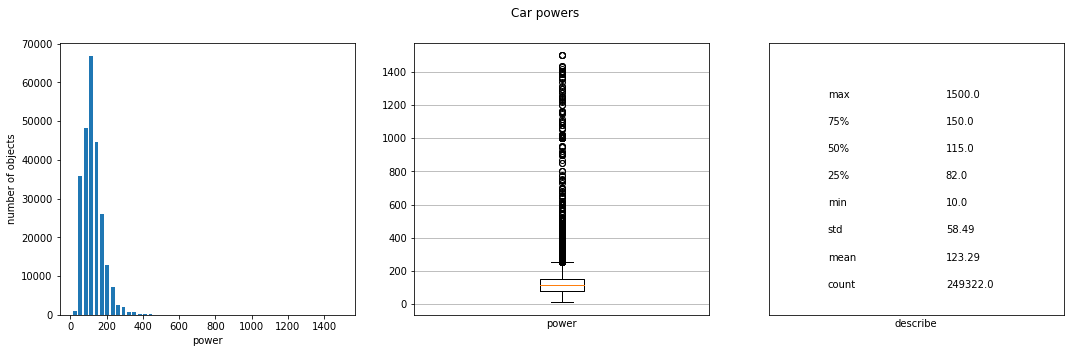

In [26]:
plot_3g(df,'power','Car powers')

***Комментарий*** Глядя на графики, можно сделать вывод, что мощность выше 400 л.с можно также отнести к выбросам и удалить объекты с такими параметрами.

In [27]:
df = df[df['power']<400]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248842 entries, 1 to 307150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              248842 non-null  int64 
 1   vehicle_type       248842 non-null  object
 2   registration_year  248842 non-null  int64 
 3   gearbox            248842 non-null  object
 4   power              248842 non-null  int64 
 5   model              248842 non-null  object
 6   kilometer          248842 non-null  int64 
 7   fuel_type          248842 non-null  object
 8   brand              248842 non-null  object
 9   not_repaired       248842 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.9+ MB


***Оптимизация памяти***

 Уменьшим разрядность данных

In [29]:
df['registration_year'] = pd.to_numeric(df['registration_year'], downcast='integer')
df['power'] = pd.to_numeric(df['power'], downcast='integer')
df['kilometer'] = pd.to_numeric(df['kilometer'], downcast='integer')
df['price'] = pd.to_numeric(df['price'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248842 entries, 1 to 307150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              248842 non-null  int16 
 1   vehicle_type       248842 non-null  object
 2   registration_year  248842 non-null  int16 
 3   gearbox            248842 non-null  object
 4   power              248842 non-null  int16 
 5   model              248842 non-null  object
 6   kilometer          248842 non-null  int32 
 7   fuel_type          248842 non-null  object
 8   brand              248842 non-null  object
 9   not_repaired       248842 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 15.7+ MB


### Выводы
Количество данных сократилось на 9 тыс строк (35%). Для моделирования оставили 10 параметров из 16-ти. Избавились от аномалий, пропусков и ненужного балласта. Объем занимаемой памяти также уменьшили на 25%. Данные готовы к работе. 249 тыс строк достаточно для выделения валидационной и тестовой выборок.

## Обучение моделей

Выберем следующие алгоритмы для обучения моделей:

1. LinearRegression
2. DecisionTreeRegressor
3. LGBMRegressor
4. CatBoostRegressor

В качестве метрики для всех моделей будем использовать RMSE. Качество моделей будем проверять на кроссвалидации c едиными глобальными переменными, и в финале на выделенной тестовой выборке. Все результаты сведем в таблицу и используем для анализа.

Время расчета считаем с помощью функции time() из библиотеки time языка python. Функция %%time для использования оказалась менее удобной, так как не позволяет занести полученный результат в переменную.

Градиентные бустинги ресурсоемкие алгоритмы, поэтому для них будем подбирать по два сходных гиперпараметра из трёх значений. Кроссвалидацию ограничим тремя циклами.

***Кодирование категориальных данных*** Будем использовать для моделей LinearRegression и DecisionTreeRegressor, две другие модели с такими данными справятся самостоятельно. Для категорий с небольшим количеством уникальных значений используем метод OHE, для длинной категории 'models', в которой более 250 значений применяем OrdinalEncoder. 

In [30]:
# Кодируем категориальные параметры. Необходимо для всех моделей, кроме CatBoostRegressor и LGBMRegressor.
# здесь используем OrdinalEncoder
df_lr = df.copy()
encoder = OrdinalEncoder()
df_lr['model'] = encoder.fit_transform(df_lr[['model']])

In [31]:
# здесь применяем OHE
df_lr = pd.get_dummies(df_lr, drop_first=True)

In [32]:
# определим параметры и таргеты. Необходимо для всех моделей, кроме CatBoost
features = df_lr.drop('price', axis=1)
target = df_lr['price']

In [33]:
#Разбиваем на тренеровочный и тестовый наборы.Так как у нас везде кросс-валидация, выборка valid не нужна.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_INIT)

### LinearRegression

Рассмотрим линейную регрессию в вариантах:

- c кроссвалидацией
- c кроссвалидация на масштабированных данных
- тестовых выборках с масштабированием и без

In [34]:
#Готовим масштабированные данные
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [35]:
#%%time - вариант 2 для расчета времени.
# Считаем rmse кросс валидацией
start_time = time.time()
model = LinearRegression()

# в переменной  rmse_lr_cv сохраняется среднее RMSE полученное по итогам кросс-валидации
rmse_lr_cv = (cross_val_score(model, features_train, target_train, cv=CV, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
time_lr_cv = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [36]:
#%%time - вариант 2 для расчета времени.
# Считаем rmse кросс валидацией с маштабированием
start_time = time.time()
model = LinearRegression()
pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

# в переменной  rmse_lr_cv_sc сохраняется среднее RMSE полученное по итогам кросс-валидации
rmse_lr_cv_sc = (cross_val_score(pipe, features_train, target_train, cv=CV,scoring='neg_mean_squared_error').mean() * -1) ** 0.5
time_lr_cv_sc = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [37]:
print('Промежуточные результаты LinearRegression: ')
print('RMSE LinearRegression кроссвалидация:                   ',rmse_lr_cv, ' время расчета сек:', time_lr_cv)
print('RMSE LinearRegression кроссвалидация с масштабированием:',rmse_lr_cv_sc, ' время расчета сек:', time_lr_cv_sc)
#print('RMSE LinearRegression на тесте:                         ',rmse_lr_test, ' время расчета сек:', time_lr_test)
#print('RMSE LinearRegression на тесте с масштабированием:      ',rmse_lr_test_sc, ' время расчета сек:', time_lr_test_sc)

Промежуточные результаты LinearRegression: 
RMSE LinearRegression кроссвалидация:                    2798.5521738929137  время расчета сек: 5.630586385726929
RMSE LinearRegression кроссвалидация с масштабированием: 2798.552173892921  время расчета сек: 6.235516786575317


**Комментарий** Нет особой разницы в результате после масштабирования. Поэтому в дальнейшем использовать этот метод не будем, так как другие алгоритмы еще менее чувствительны к этому критерию.

### DecisionTreeRegressor

In [38]:
# с помощью GridSearch подбираем лучшую глубину дерева
max_depth_list = list(range(2, 21))
params = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[RANDOM_INIT]}]

In [39]:
#%%time
start_time = time.time()
model= DecisionTreeRegressor()
clf = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=CV)
clf = clf.fit(features_train, target_train)
time_dtr_cv = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [40]:
# Сохраняем расчитанные гиперпараметры в переменной  best_params
best_params_dtr = clf.best_params_

# в этой строке сохраняется среднее лучшее RMSE полученное по итогам кросс-валидации
rmse_dtr_cv = (max(clf.cv_results_['mean_test_score'])*-1) ** 0.5

In [41]:
print('Промежуточные результаты DecisionTreeRegressor: ')
print('Глубина дерева:',best_params_dtr['max_depth'])
print('RMSE DecisionTreeRegressor по итогам кросс валидации: ', rmse_dtr_cv, ' время расчета сек:',time_dtr_cv )

Промежуточные результаты DecisionTreeRegressor: 
Глубина дерева: 14
RMSE DecisionTreeRegressor по итогам кросс валидации:  1930.9274880897435  время расчета сек: 48.218334674835205


### LGBMRegressor

In [42]:
# чистим память от лишних переменных
del features_train_scaled 
del features_test_scaled
del df_lr
del features 
del target
df_lgbmr = df

In [43]:
# Переводим категорийные параметры в тип данных 'category', что бы алгоритм мог с ними работать
for column in cat_features:
    df_lgbmr[column] = df_lgbmr[column].astype('category')

In [44]:
# список наименований features
X = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 
     'kilometer', 'fuel_type', 'brand', 'not_repaired']
# наименование колонки, целевого параметра -  target
y = ['price']

In [45]:
# разделяем тестовую, валидационную и учебную выборки
train_lgbmr, test_lgbmr = train_test_split(df_lgbmr,test_size=0.25,random_state=RANDOM_INIT)

In [46]:
# C помощью GridSearch подберем learning_rate, остальные гиперпараметры зафиксируем.
params = [{'num_leaves':[50, 100, 200], 
           'learning_rate':[0.1, 0.3, 0.5], 
           'random_state':[RANDOM_INIT]}] 

In [47]:
#%%time
start_time = time.time()
model = LGBMRegressor() 
clf = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=CV)
clf = clf.fit(train_lgbmr[X], train_lgbmr[y])
time_lgbmr_cv = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [48]:
# best_params - сохраняем параметры, которые дают лучший результат и используем их при обучении на тестовой выборке
best_params_lgbmr = clf.best_params_

# при получении метрики, используем функцию max(), так как в cv_results_ скоры отрицательные, и после инверсии, это даст минимум
# в этой строке сохраняется среднее лучшее RMSE полученное по итогам кросс-валидации
rmse_lgbmr_cv = (max(clf.cv_results_['mean_test_score'])*-1) ** 0.5

In [49]:
print('Промежуточные результаты LGBMRegressor:')
print('learning_rate:',best_params_lgbmr['learning_rate'], ' num_leaves:', best_params_lgbmr['num_leaves'])
print('RMSE LGBMRegressor cv      : ', rmse_lgbmr_cv, ' время расчета сек:',time_lgbmr_cv )


Промежуточные результаты LGBMRegressor:
learning_rate: 0.1  num_leaves: 200
RMSE LGBMRegressor cv      :  1575.3586763784924  время расчета сек: 358.0452160835266


### CatBoostRegressor

**Комментарий** Так как этому алгоритму нет необходимости в кодировании категорий, для него отдельно готовим тестовую, валидационную и обучающую выборки. Используем метод Михайлова - не выделять отдельные датафреймы для параметров и таргетов, а использовал списки с наименованием "фичей" - X и таргет - y и уже их использовать в качестве параметров в датафреймах. Алгоритм ресурсоемкий, поэтому предварительно очистим память от не использующихся далее данных.

In [50]:
# разделяем тестовую, валидационную и учебную выборки
train, test = train_test_split(df,test_size=0.4,random_state=RANDOM_INIT)
val, test = train_test_split(test,test_size=0.5,random_state=RANDOM_INIT)

In [51]:
# параметры для бустинга. В GridSearch подбираем learning_rate, можно подбирать больше параметров, не позволяет ресурс
params = {'cat_features':[cat_features],
          'random_state': [RANDOM_INIT],
          'verbose':[0], 
          'learning_rate':[0.1, 0.3, 0.5],
          'iterations':[50, 100, 200]}

In [52]:
#%%time
start_time = time.time()
model = CatBoostRegressor()
clf = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv = CV)
clf = clf.fit(train[X],train[y], eval_set=(val[X],val[y]))
time_cbr_cv = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [53]:
# best_params - сохраняем параметры, которые дают лучший результат и используем их при обучении на тестовой выборке
best_params_cbr = clf.best_params_

# при получении метрики, используем функцию max(), так как в cv_results_ скоры отрицательные, и после инверсии, это даст минимум
# в этой строке сохраняется среднее лучшее RMSE полученное по итогам кросс-валидации
rmse_cbr_cv = (max(clf.cv_results_['mean_test_score'])*-1) ** 0.5

In [54]:
print('Промежуточные результаты CatBoostRegressor: ')
print('learning_rate: ',best_params_cbr['learning_rate'],' iterations: ',best_params_cbr['iterations'])
print('RMSE CatBoostRegressor по итогам кросс валидации: ', rmse_cbr_cv, ' время расчета сек:',time_cbr_cv )

Промежуточные результаты CatBoostRegressor: 
learning_rate:  0.3  iterations:  200
RMSE CatBoostRegressor по итогам кросс валидации:  1658.0810518788799  время расчета сек: 725.818422794342


## Анализ моделей

In [55]:

index = ['LinearRegression', 'LinearRegression_scaled', 'DecisionTreeRegressor', 
         'CatBoostRegressor','LGBMRegressor']

data = {'RMSE на кросс валидации':[rmse_lr_cv, rmse_lr_cv_sc, rmse_dtr_cv, rmse_cbr_cv, rmse_lgbmr_cv],
        'Время кросс валидации, sec':[time_lr_cv, time_lr_cv_sc, time_dtr_cv, time_cbr_cv, time_lgbmr_cv]}


eda_models = pd.DataFrame(data=data, index=index)
eda_models = eda_models.sort_values(by='RMSE на кросс валидации', ascending=True)

display(eda_models)

,RMSE на кросс валидации,"Время кросс валидации, sec"
LGBMRegressor,1575.358676,358.045216
CatBoostRegressor,1658.081052,725.818423
DecisionTreeRegressor,1930.927488,48.218335
LinearRegression,2798.552174,5.630586
LinearRegression_scaled,2798.552174,6.235517


***Комменатрий*** Лучшая метрика RMSE получена методом LGBMRegression. Считаем результат на тестовых данных, с учетом лучших гиперпараметров, полученных с помощью GridSearchCV

In [56]:
#%%time
# Используя лучшие гиперпараметры считаем метрику на тесте
start_time = time.time()
model = LGBMRegressor(**best_params_lgbmr)
model = model.fit(train_lgbmr[X],train_lgbmr[y])
rmse_lgbmr_test = mean_squared_error(test_lgbmr[y], model.predict(test_lgbmr[X])) ** 0.5
time_lgbmr_test = time.time() - start_time # время счета в секундах кода от start_time до текущей строки

In [57]:
print('Результаты LGBMRegressor:')
print('learning_rate:',best_params_lgbmr['learning_rate'], ' num_leaves:', best_params_lgbmr['num_leaves'])
print('RMSE LGBMRegressor cv      : ', rmse_lgbmr_cv, ' время расчета сек:',time_lgbmr_cv )
print('RMSE LGBMRegressor на тесте: ', rmse_lgbmr_test, ' время расчета сек:',time_lgbmr_test)

Результаты LGBMRegressor:
learning_rate: 0.1  num_leaves: 200
RMSE LGBMRegressor cv      :  1575.3586763784924  время расчета сек: 358.0452160835266
RMSE LGBMRegressor на тесте:  1585.0851051468837  время расчета сек: 21.595305919647217


### Выводы*

1. LGBMRegressor лучший rmse при хорошей* скорости счета. Рекомедуется к использованию в данном проекте, на текущем техническом ресурсе, особенно эффективен на платформе google colab. Cкорость вычислений этого алгоритма в google colab выше в пять раз чем в jupyter на платформе яндекс.практикум. При этом скорость вычислений catboost от смены платформы не меняется . Итоговый результат RMSE на тестовой выборке = 1585, практически идентичен среднему кросс-валидационному. Эту модель можно рекомендовать для практического применения в данной задаче.

2. CatBoostRegressor хорошая rmse, при этом ресурсоемкий алгоритм. 

3. DecisionTreeRegressor средний результат при высокой скорости счета. Итог: Можно использовать, когда необходимо получить быстрый результат, при этом точность не является ключевым критерием. Для быстрых решений.

4. LinearRegression посредственный результат при любых настройках. Вердикт: Для расчета прогноза стоимости автомобиля не использовать.

'*' Скорость вычислений аппаратно и платформо - зависимая вещь. Ресурсы выделяемые серверами для задач пользователей зависят от количества пользователей. Например, в выходой день скорость счета кроссвалидации catboost была в несколько раз выше чем в будний день. Скорость вычислений зависит от настроек гиперпараметров и сравнивать сложные алгоритмы дело неблагодарное, так как в рамках данного проекта все их возможности не были использованы. 

## Выводы

Проведена предварительная подготовка данных.

1. Удалены 6 параметров не участвующих в обучении моделей, так как не влияют на целевой параметр - цену автомобиля.
2. Удалены дубликаты - 24тыс строк
3. Произведена замена пропусков в колонках 
4. Удалены аномалии в числовых параметрах, определены границы реальных значений для цены автомобиля, мощности и года регистрации. Выбросы отфильтрованы.

Проведено предварительно обучение моделей.
1. Выбраны модели: LinearRegression, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor
2. Проведено обучение с целью выявления оптимальных гиперпараметров. Для этого использовался метод GridSearchCV c метрикой RMSE 
3. Проведен замер времени выполнения процедур

Проведен анализ результатов
1. Проведено обучение моделей на оптимальных параметрах, расчитан прогноз результатов по тестовым выборкам, посчитаны средние метрики при кросс-валидации.
RMSE.
2. Проведен замер времени обучения и прогнозирования.
3. Данные сведены в таблицу и сформированы следующие выводы: Кроме линейной регрессии, все методы можно использовать на практике. Наиболее применим метод градиентного бустинга с алгоритмом - LGBMRegressor. И хотя метод незначительно выиграл в точности методу catboost, он давал приемлемые сроки расчетов при  лучших rmse. Кроме того выяснилась сильная аппаратно-платформенная зависимость методов. LGBMRegressor можно еще ускорить, если считать модели на серверах google colab.




## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей